# Анализ стартапа, который продаёт продукты питания

Цель: анализировать поведение пользователей мобильного приложения.

Задачи: 
Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
Исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.
Выяснить, какой шрифт лучше.

## Подготовка

In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime
import numpy as np
import math 
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import scipy.stats as stats
import warnings
from plotly import graph_objects as go 

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep="\t")

In [3]:
def initial(data):
    return (display(data.sample()),
            display(data.info()),
            display(data.describe()),
            print("Пропусков всего:"),
            display(data.isna().sum()),
            print("Дубликатов всего:"),
            display(data.duplicated().sum())
           )

initial(data)

,EventName,DeviceIDHash,EventTimestamp,ExpId
94026,MainScreenAppear,3766717525526906414,1564840640,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


Пропусков всего:


EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

Дубликатов всего:


413

(None, None, None, None, None, None, None)

Что нужно сделать: привести столбец с датой и временем в нужной формат. Создать отдельно колонку с датой. Привести названия к нижнему регистру, переименовать. Посмотреть долю дубликатов. 

In [4]:
data['EventTimestamp'] = pd.to_datetime(data['EventTimestamp'], unit = 's')

In [5]:
data['date'] = pd.to_datetime(data['EventTimestamp']).dt.date

In [6]:
data.columns= data.columns.str.lower()

In [7]:
data.columns = ['event_name', 'device_id', 'event_time', 'exp_id', 'date']

In [8]:
len(data.drop_duplicates()) / len(data) * 100

99.83082506574475

In [9]:
data = data.drop_duplicates()

## Изучение данных

In [10]:
print('Всего событий в логе:', len(data))
print('Всего пользователей в логе:', data['device_id'].nunique())
print('Минимальная дата:', data['date'].min())
print('Максимальная дата:', data['date'].max())

Всего событий в логе: 243713
Всего пользователей в логе: 7551
Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-07


In [11]:
data.groupby('device_id').agg({'event_name': 'count'}).mean().round()


event_name    32.0
dtype: float64

Итак, в среднем событий приходится на пользователя: 32 события 

Построим гистограмму по дате, чтобы посмотреть распределение событий 

Text(0.5, 1.0, 'Гистограмма по дате и времени')

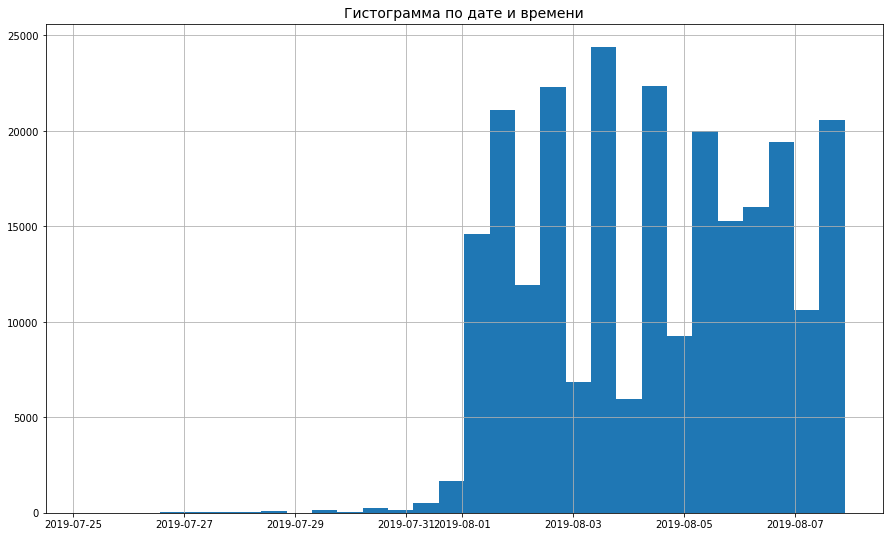

In [12]:

data['event_time'].hist(bins=30, figsize=(15,9))
plt.title('Гистограмма по дате и времени', fontsize=14)




Мы видим, что до 1 августа у нас нет полных данных. Создадим новый массив с 1 по 7 августа, в этом промежутке у нас имеются данные для анализа. 

In [13]:
new_data = data[data['date'] >= pd.to_datetime('2019-08-01', format = '%Y-%m-%d')]
new_data

,event_name,device_id,event_time,exp_id,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [14]:

print('Всего удалено событий:', len(data) - len(new_data))
print('Всего удалено пользователей:', data['device_id'].nunique() - new_data['device_id'].nunique())

Всего удалено событий: 2826
Всего удалено пользователей: 17


Без дополнительных расчетов видно, что данных удалено мало. Подверждается гистограмма, что данных там практически не было.

In [15]:
new_data.groupby('exp_id').agg({'device_id': 'count'})

,device_id
exp_id,
246,79302
247,77022
248,84563


Во всех трех группах есть пользователи, распределение относительно ровное.

Мы оставили данные с 1 по 7 августа. В среднем событий приходится на пользователя: 32 события. 

## Изучаем воронку событий


    В каком порядке происходят события? Все ли они выстраиваются в последовательную цепочку? Что можно убрать?


In [16]:
events_count = new_data.groupby('event_name').agg({'device_id': 'count'}).sort_values(by='device_id', ascending=False)
events_count

,device_id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Порядок событий: главный экран, экран предложений товаров, корзина, оплата. Туториал можно убрать из анализа, он не является обязательным пунктом, и его частота сильно ниже, чем у других событий.

In [17]:
# сортируем по числу пользователей
users_count = new_data.groupby('event_name').agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending=False)
users_count['percent'] = users_count['device_id'].apply(lambda x: round(x/new_data['device_id'].nunique()*100)).astype('str') + '%'
users_count

,device_id,percent
event_name,,
MainScreenAppear,7419,98%
OffersScreenAppear,4593,61%
CartScreenAppear,3734,50%
PaymentScreenSuccessful,3539,47%
Tutorial,840,11%


In [ ]:
# убираем туториал 
users_new = users_count.query('event_name != "Tutorial"')
# строим воронку
fig = go.Figure(
    go.Funnel(
        y=[
            'MainScreenAppear',
            'OffersScreenAppear',
            'CartScreenAppear',
            'PaymentScreenSuccessful',
        ],
        x=list(users_new ['device_id']),
    )
)
fig.show() 

Больше всего пользователей мы теряем на втором шаге. Всего 61.9% переходят с главного экрана до экрана с предложениями. 47.7% от пользователей на первом шаге остаются на шаге оплаты.   

In [19]:
data_new = new_data.query('event_name != "Tutorial"')
data_new

,event_name,device_id,event_time,exp_id,date
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
2833,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


Порядок событий: главный экран, экран предложений товаров, корзина, оплата. Убрали туториал из массива для анализа. Больше всего пользователей мы теряем на втором шаге. Всего 61.9% переходят с главного экрана до экрана с предложениями. 47.7% от пользователей на первом шаге остаются на шаге оплаты. 


## Результаты эксперимента

 

Посмотрим на распределение пользователей между группами и проведем Z-тест на проверку гипотезы о равенстве долей пользователей на каждом шаге воронки.

Зададим гипотезы для тестов:

H0: Разница между группами отсутствует  

H1: Разница между группами существует  



- Между выборками 246 и 247
- С группой с изменённым шрифтом
- С каждой из контрольных групп в отдельности по каждому событию
- С объединненой контрольной группой
Всего будет проведено 16 тестов. 



 

In [20]:
def check_hypothesis (successes1, successes2, trials1, trials2):
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value


trials = data_new.groupby('exp_id').agg({'device_id': 'nunique'})
display(trials)
funnel = data_new.pivot_table(index = 'event_name', columns = 'exp_id', values = 'device_id', aggfunc = 'nunique')
display(funnel)

print(check_hypothesis(funnel.loc['CartScreenAppear', 246], funnel.loc['CartScreenAppear', 247],
                       trials.loc[246].values[0], trials.loc[247].values[0]))
print(check_hypothesis(funnel.loc['CartScreenAppear', 246], funnel.loc['CartScreenAppear', 248],
                       trials.loc[246].values[0], trials.loc[248].values[0]))
 

,device_id
exp_id,
246,2483
247,2512
248,2535


exp_id,246,247,248
event_name,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181


0.22867643757335676
0.08067367598823139


Пользователей в каждой экспериментальной группе: 246 - 2483 пользователя, 247 - 2512 пользователя, 248 - 2535 пользователя. Также посмотрели разделение пользователей по событиями, данные по всем трем группам практически не разнятся. 
Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. 

In [25]:
# создаем объединенный столбец 
comb_data = data_new.query('exp_id in [246, 247]')
comb_data['exp_id'] = '246 + 247'

data_new = data_new.append(comb_data)



trials = data_new.groupby('exp_id').agg({'device_id': 'nunique'})
display(trials)

funnel = data_new.pivot_table(index = 'event_name', columns = 'exp_id', values = 'device_id', aggfunc = 'nunique')
display(funnel)

event = 'CartScreenAppear'

print(check_hypothesis(funnel.loc[event, 248], funnel.loc[event, 246],
                       trials.loc[248].values[0], trials.loc[246].values[0]))

print(check_hypothesis(funnel.loc[event, 248], funnel.loc[event, 247],
                       trials.loc[248].values[0], trials.loc[247].values[0]))

print(check_hypothesis(funnel.loc[event, 248], funnel.loc[event, '246 + 247'],
                       trials.loc[248].values[0], trials.loc['246 + 247'].values[0]))

pd.set_option('chained_assignment', None)


,device_id
exp_id,
246,2483
247,2512
248,2535
246 + 247,4995


exp_id,246,247,248,246 + 247
event_name,,,,
CartScreenAppear,1266,1238,1230,2504
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
PaymentScreenSuccessful,1200,1158,1181,2358


0.08067367598823139
0.5878284605111943
0.18683558686831558


Самое популярное событие - главный экран. Мы вывели на экран таблицу с числом пользователей каждой контрольной группы с разбивкой по событиями. Добавили в результаты объединеную контрольную группу. Был выбран уровень уровень значимости - 0.05. Также проведем проверку с уровенем 0.01. Стоит учесть, что у нас множественный тест, поэтому применими поправку Бонферрони. 


In [22]:
p_values = []
for groups in [[246, 247], [246, 248], [247, 248], ['246 + 247', 248]]:
    for event_name in data_new['event_name'].unique():
        p = check_hypothesis(funnel.loc[event_name, groups[0]], funnel.loc[event_name, groups[1]],
                             trials.loc[groups[0]].values[0], trials.loc[groups[1]].values[0])
        p_values += [[groups[0], groups[1], event_name, p]]
        
p_values = pd.DataFrame(p_values, columns = ['A', 'B', 'event_name', 'p-value'])

alpha = 0.05

alpha = alpha / p_values.shape[0]

p_values['reject_h0'] = p_values['p-value'] < alpha 
p_values 



,A,B,event_name,p-value,reject_h0
0,246,247,MainScreenAppear,0.752670,False
1,246,247,OffersScreenAppear,0.247861,False
2,246,247,CartScreenAppear,0.228676,False
3,246,247,PaymentScreenSuccessful,0.114466,False
4,246,248,MainScreenAppear,0.338711,False
5,246,248,OffersScreenAppear,0.214425,False
6,246,248,CartScreenAppear,0.080674,False
7,246,248,PaymentScreenSuccessful,0.216930,False
8,247,248,MainScreenAppear,0.519496,False
9,247,248,OffersScreenAppear,0.933375,False


In [23]:
p_values = []
for groups in [[246, 247], [246, 248], [247, 248], ['246 + 247', 248]]:
    for event_name in data_new['event_name'].unique():
        p = check_hypothesis(funnel.loc[event_name, groups[0]], funnel.loc[event_name, groups[1]],
                             trials.loc[groups[0]].values[0], trials.loc[groups[1]].values[0])
        p_values += [[groups[0], groups[1], event_name, p]]
        
p_values = pd.DataFrame(p_values, columns = ['A', 'B', 'event_name', 'p-value'])

alpha = 0.01

alpha = alpha / p_values.shape[0]

p_values['reject_h0'] = p_values['p-value'] < alpha 
p_values 


,A,B,event_name,p-value,reject_h0
0,246,247,MainScreenAppear,0.752670,False
1,246,247,OffersScreenAppear,0.247861,False
2,246,247,CartScreenAppear,0.228676,False
3,246,247,PaymentScreenSuccessful,0.114466,False
4,246,248,MainScreenAppear,0.338711,False
5,246,248,OffersScreenAppear,0.214425,False
6,246,248,CartScreenAppear,0.080674,False
7,246,248,PaymentScreenSuccessful,0.216930,False
8,247,248,MainScreenAppear,0.519496,False
9,247,248,OffersScreenAppear,0.933375,False


С поправкой Бонферрони не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя. Следовательно, можно сделать первоначальные выводы о том, что новый шрифт никак не повлиял на работу приложения.

Выводы по проекту: 

- Анализ проводился по данным с 1 августа по 7 августа. Остальные данные были удалены.

- В среднем на пользователя приходится 32 события.

- В приложении четыре основых события: главный экран, экран предложений товаров, корзина, оплата. 

- Туториал, как событие, необязательное. Его удалили из данных. 

- Всего 61.9% переходят с главного экрана до экрана с предложениями.

- Самое популярное событие - "главный экран".

- Было решено провести тесты с поправкой Бонферрони.

- Разницу между выборками 246 и 247 не нашли.

- Разницу по событиями группы с новом шрифтом с группами со старым шрифтом не нашли. 

- Сравнение с объединённой контрольной группой дало отрицательный результат. 

- Были сделаны первоначальные выводы о том, что новый шрифт никак не повлиял на работу приложения.
